# Stiff ODE Solvers

Learn about solvers suitable for stiff systems, including BDF, Radau, and LSODA.

### Overview of solve_ivp Methods in SciPy

scipy.integrate.solve_ivp provides several ODE solvers tailored to different problem types.
These methods differ in algorithm type (explicit vs. implicit), order of accuracy, and their suitability for stiff vs. non-stiff problems.

- Explicit methods compute future values using only current information.
- Implicit methods solve algebraic equations at each step — more stable for stiff systems.
- **Stiff problems** are systems where certain components evolve much faster than others, requiring solvers that remain stable even with large step sizes.

Stiff Solvers (Implicit Methods)
| Method    | Type                                          | Use Case                                                 |
| --------- | --------------------------------------------- | -------------------------------------------------------- |
| `'Radau'` | Implicit Runge-Kutta                          | Very stable for stiff problems                           |
| `'BDF'`   | Backward Differentiation Formula (multi-step) | Best for large stiff systems                             |
| `'LSODA'` | Automatic (Adams + BDF)                       | Automatically detects stiffness and switches accordingly |

In practice, there's often a tradeoff between computational speed and solution accuracy. The choice of solver depends on:
- Whether the ODE system is stiff or non-stiff
- The required precision of the solution
- The available computational resources

### What Is an Explicit Method?

* **Explicit Euler** (Forward Euler) approximates:
$$
\frac{y(x + h) - y(x)}{h} = f(x, y) 
\Rightarrow 
y_{n+1} = y_n + h \cdot f(t_n, y_n)
$$



* It’s straightforward but **conditionally stable** — when the step size $h$ is too large, explicit methods can produce oscillations or blow up, especially when solving stiff equations ([John D. Cook Consulting][1], [John D. Cook Consulting][2]).



### 🧩 What Is an Implicit Method?

* **Implicit Euler** (Backward Euler) solves:
$$
\frac{y(x + h) - y(x)}{h} = f(x + h, y(x + h)) 
\Rightarrow 
y_{n+1} = y_n + h \cdot f(t_{n+1}, y_{n+1})
$$


* Here, $y_{n+1}$ appears on both sides — requiring a nonlinear solver (e.g. Newton’s method) ([John D. Cook Consulting][1]).

* It is **A-stable** — remains stable even with large step sizes for decaying solutions, making it well-suited for stiff systems.



## ⚙️ Stiff Solver Methods in SciPy

SciPy provides the following solvers specifically designed for stiff problems:

### 🔸 `Radau`
- Implicit Runge-Kutta method of order 5
- A-stable and suitable for very stiff systems
- Solves using collocation

Mathmatical Equations:
$$ Y_i = y_n + h \sum_{j=1}^{s} a_{ij} f(t_n + c_j h, Y_j), \quad i = 1, \dots, s $$
$$ y_{n+1} = y_n + h \sum_{j=1}^{s} b_j\, f(t_n + c_j h,\, Y_j) $$

- a_ij, b_j, c_j come from the **Butcher tableau**
- Y_j are the internal stage approximations


### 🔸 `BDF` (Backward Differentiation Formula)
- Multi-step method: $$ y_{n+1} \rightarrow \text{depends on } y_n,\, y_{n-1},\, y_{n-2},\, \dots $$
- Suitable for large stiff systems
- Stable and efficient

Mathmatical Equations:
- General BDF formula (order k):
$$ \sum_{j=0}^{k} \alpha_j y_{n-j} = h \cdot f(t_n, y_n) $$
- 2-Step BDF:
$$ \frac{3y_n - 4y_{n-1} + y_{n-2}}{2h} = f(t_n, y_n)
 $$


### 🔸 `LSODA`
- Automatically switches between non-stiff (Adams) and stiff (BDF) as needed
- Great for systems where stiffness turns on/off

All of these solvers benefit from providing a Jacobian or structure info (see above).


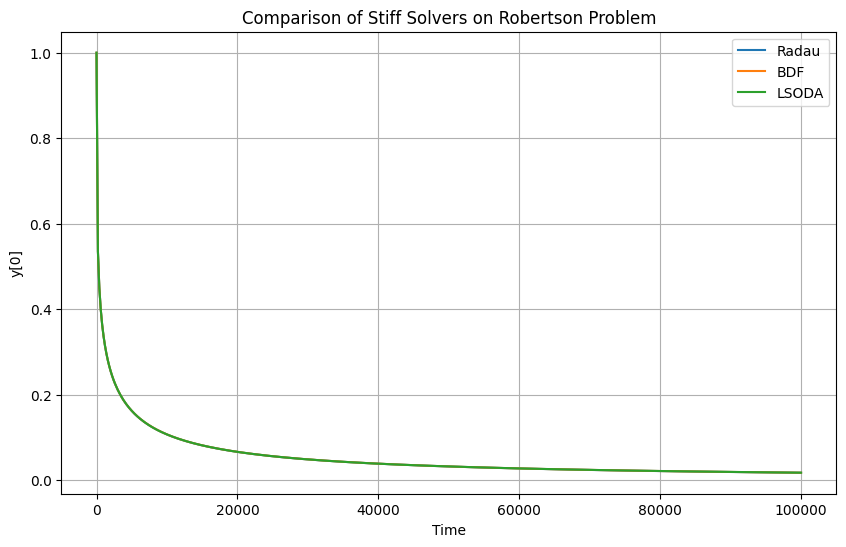

Method: Radau
  Time     = 0.2493 sec
  Steps    = 500
  Func evals = 391

Method: BDF
  Time     = 0.1873 sec
  Steps    = 500
  Func evals = 269

Method: LSODA
  Time     = 0.0862 sec
  Steps    = 500
  Func evals = 283



In [25]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

# Robertson problem (classic stiff test case)
def robertson(t, y):
    dy = np.zeros(3)
    dy[0] = -0.04*y[0] + 1e4*y[1]*y[2]
    dy[1] = 0.04*y[0] - 1e4*y[1]*y[2] - 3e7*y[1]**2
    dy[2] = 3e7*y[1]**2
    return dy

y0 = [1, 0, 0]
t_span = (0, 1e5)
t_eval = np.linspace(*t_span, 500)

methods = ['Radau', 'BDF', 'LSODA']
'''
YOU CAN TRY NON STIFF METHODS AS WELL AND SEE HOW THEY WILL NOT WORK OR TAKE LONGER TIME AND EVALUATIONS
 'RK45', 'RK23', 'DOP853'
'''
solutions = {}

for method in methods:
    start = time.time()
    sol = solve_ivp(robertson, t_span, y0, method=method, t_eval=t_eval)
    duration = time.time() - start
    solutions[method] = {
        'sol': sol,
        'time': duration,
        'nfev': sol.nfev,
        'n_steps': len(sol.t)
    }

# Plot
plt.figure(figsize=(10,6))
for method in methods:
    plt.plot(solutions[method]['sol'].t, solutions[method]['sol'].y[0], label=f"{method}")
plt.legend()
plt.title("Comparison of Stiff Solvers on Robertson Problem")
plt.xlabel("Time")
plt.ylabel("y[0]")
plt.grid(True)
plt.show()

# print performace summary
for method in methods:
    print(f"Method: {method}")
    print(f"  Time     = {solutions[method]['time']:.4f} sec")
    print(f"  Steps    = {solutions[method]['n_steps']}")
    print(f"  Func evals = {solutions[method]['nfev']}")
    print()



## 🔍 Detecting Stiffness

You might suspect a system is stiff if:
- RK methods (RK45, RK23) take extremely small step sizes
- Solver throws warnings about step size underflow
- You see slow runtimes even for seemingly simple dynamics
- System includes very fast/slow processes (e.g. chemical reactions)

Use `LSODA` if you're unsure — it will automatically switch to stiff handling.


## Why the Jacobian Matters in Stiff Problems

To solve this nonlinear equation for y_n+1 , both BDF and Radau internally use Newton's method at every time step.

A multi-step, implicit method. Example for BDF-2:
$$ \frac{3y_n - 4y_{n-1} + y_{n-2}}{2h} = f(t_n, y_n)$$

to solve this equation for y_n → Newton's method is used

### Newton's Method

We want to solve the nonlinear equation:

$$
F(y_n) = 0
$$

Where:

$$
F(y_n) := \frac{3y_n - 4y_{n-1} + y_{n-2}}{2h} - f(t_n, y_n)
$$


### Newton Iteration

We iteratively update $y_n$ using:

$$
y_n^{(k+1)} = y_n^{(k)} - \left[ J_F(y_n^{(k)}) \right]^{-1} \cdot F(y_n^{(k)})
$$

Where:

* $y_n^{(k)}$ is the current guess for $y_n$
* $F(y_n)$ is defined as above
* $J_F(y_n^{(k)}) = \frac{dF}{dy}$ is the **Jacobian**


### 🔑 Jacobian-Related Parameters in `solve_ivp`

| Parameter         | Type     | Description                                                                 | When to Use                                      |
|------------------|----------|-----------------------------------------------------------------------------|--------------------------------------------------|
| `jac`            | callable or array | Function returning Jacobian \( J \), or constant array                 | For stiff systems with known or structured Jacobian |
| `jac_sparsity`   | 2D array | Boolean sparsity pattern of Jacobian                                        | For large sparse Jacobians (speeds up computation) |
| `lband`, `uband` | int      | Lower/upper bandwidth if Jacobian is banded                                 | For banded matrices (common in spatial ODEs/PDEs) |

---

### Why It Helps

- Newton-type solvers use the Jacobian to converge quickly.
- A **sparse** or **banded** Jacobian reduces the work needed to solve linear systems at each step.
- If you don’t supply it, SciPy will approximate it using finite differences (slower, less accurate).

---

### Best Practice

If you're using `method='BDF'` or `'Radau'`, and:
- You know the Jacobian: **pass it via `jac`**
- It's sparse(Only diagonal is non-zero): **use `jac_sparsity`**
- It's banded(Only nearby diagonals are non-zero): **use `lband`, `uband`**

This can dramatically speed up your solver on large, stiff problems.


Method: BDF with Jacobian
  Time     = 0.0630 sec
  Steps    = 10000
  Func evals = 269

Method: BDF without Jacobian
  Time     = 0.0662 sec
  Steps    = 10000
  Func evals = 269



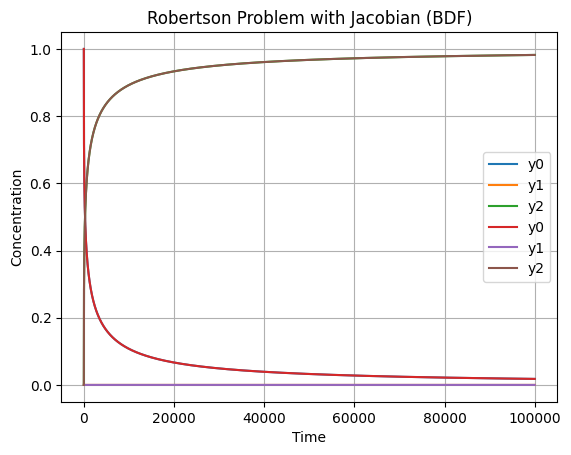

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def robertson(t, y):
    y0, y1, y2 = y
    return [
        -0.04*y0 + 1e4*y1*y2,
         0.04*y0 - 1e4*y1*y2 - 3e7*y1**2,
         3e7*y1**2
    ]

def robertson_jac(t, y):
    y0, y1, y2 = y
    return np.array([
        [-0.04,           1e4*y2,         1e4*y1],
        [ 0.04,  -1e4*y2 - 6e7*y1, -1e4*y1],
        [ 0.0,            6e7*y1,         0.0  ]
    ])

# Initial conditions and time span
y0 = [1, 0, 0]
t_span = (0, 1e5)
t_eval = np.linspace(*t_span, 10000)

# Solve using BDF with Jacobian
start_01 = time.time()
sol_01 = solve_ivp(robertson, t_span, y0, method='BDF', jac=robertson_jac, t_eval=t_eval)
duration_01 = time.time() - start_01
print(f"Method: BDF with Jacobian")
print(f"  Time     = {duration_01:.4f} sec")
print(f"  Steps    = {len(sol_01.t)}")
print(f"  Func evals = {sol_01.nfev}")
print()

start_02 = time.time()
sol_02 = solve_ivp(robertson, t_span, y0, method='BDF', t_eval=t_eval)
duration_02 = time.time() - start_02
print(f"Method: BDF without Jacobian")
print(f"  Time     = {duration_02:.4f} sec")
print(f"  Steps    = {len(sol_02.t)}")
print(f"  Func evals = {sol_02.nfev}")
print()

# Plot result
plt.plot(sol_01.t, sol_01.y[0], label='y0')
plt.plot(sol_01.t, sol_01.y[1], label='y1')
plt.plot(sol_01.t, sol_01.y[2], label='y2')

plt.plot(sol_02.t, sol_02.y[0], label='y0')
plt.plot(sol_02.t, sol_02.y[1], label='y1')
plt.plot(sol_02.t, sol_02.y[2], label='y2')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Robertson Problem with Jacobian (BDF)')
plt.legend()
plt.grid(True)
plt.show()
